### Plot line charts to show housing price and inventory levels in selected TX Market (Dallas, Austin, Houston) over time

In [51]:
# Import a US housing dataset, extract Texas housing data

In [52]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

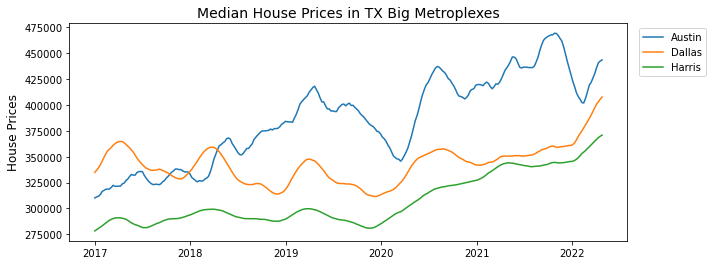

In [53]:
#import US housing dataset
housing_raw = pd.read_csv("housing_data.csv", 
            parse_dates = ["period_begin", "period_end"], dtype = {"region_name" : "category", "total_homes_sold":"Int32"}
           )
# extract Texas housing data, use only TX county names
tx_housing = housing_raw[housing_raw["region_name"].str.contains("TX")].assign(region_name = housing_raw["region_name"].str[0:-11])

#use pivot table to get median active list price of all counties
tx_price_pivot = tx_housing.pivot_table(index = "period_begin", columns = "region_name", values = "median_active_list_price")

#get median_active_list_price of 3 counties
three_counties = tx_price_pivot.loc[:,["Austin", "Dallas", "Harris"]]
#plot line charts to show 3 counties median active list price 
fig, ax = plt.subplots(figsize = (10, 4)) #quick way: ax.plot(three_counties) - ax.legend(three_counties.columns)

#plot individual plots with individual labels/legend
ax.plot(three_counties.index, three_counties["Austin"], label = "Austin")
ax.plot(three_counties.index, three_counties["Dallas"], label = "Dallas")
ax.plot(three_counties.index, three_counties["Harris"], label = "Harris")

ax.set_title("Median House Prices in TX Big Metroplexes", fontsize = 14)
ax.set_ylabel("House Prices", fontsize = 12)

ax.legend(bbox_to_anchor = (1.15, 1)) #bbox_to_anchor = () to push the legend box outside of the chart

### Plot line charts to show housing price in Dallas and Austin before and after covid break out (2020-03-21)
#### (adding a vertical line, custom axis ticks)

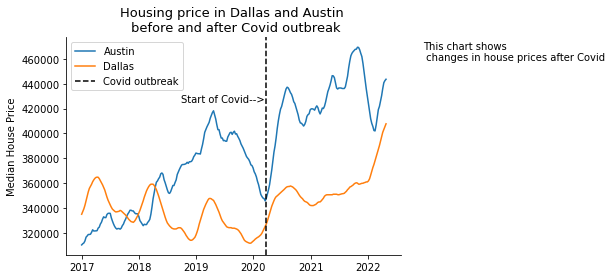

In [54]:
# get median_active_list_price of Austin and Dallas
au_da= tx_price_pivot.loc[:, ["Austin", "Dallas"]]

#add vertical line at the position of March 21, 2020: first, find date gaps between default date Jan1,1970  and Mar21, 2020, then use ax.axvline

datetime.datetime(2020,3,21)-datetime.datetime(1970,1,1)

fig, ax = plt.subplots()
ax.plot(au_da["Austin"], label = "Austin")
ax.plot(au_da["Dallas"], label = "Dallas")
ax.set_ylabel("Median House Price")
ax.axvline(18342, ls = "--", label = "Covid outbreak", color = "black") #18342 is days between default date and date we want the vline to be: 20-03-21
ax.legend()
ax.set_title("Housing price in Dallas and Austin \n before and after Covid outbreak", fontsize = 13)
#add text to our chart: ax.tex(x-cooridnate, y-coordinate, "text")
ax.text(17800, 425000, "Start of Covid-->")

#add explanation text to the chart with fig.text(a, b, "text", fontname = ..., fontsize = ..., color=..)-bbox_to_anchor: (0,0): bottom left, (0:1): top left, (1,1): top right)
fig.text(0.95, 0.8, "This chart shows \n changes in house prices after Covid")

#remove top and right border
ax.spines[["right", "top"]].set_visible(False) #or ax.spines["right"].set_visible(False)  and ax.spines["top"].set_visible(False)

### Plot dual axis chart: Price vs inventory in Dallas (different y labels and y units) (1 line chart, 1 bar chart)

<function matplotlib.pyplot.show(close=None, block=None)>

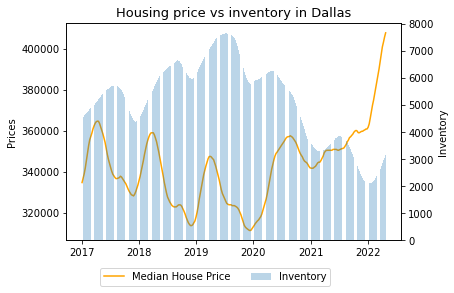

In [55]:
#get TX housing data, set "period_begin" the index column
tx_housing_period_begin_index = (housing_raw[housing_raw["region_name"].str.contains("TX")]
              .assign(region_name = housing_raw["region_name"].str[0:-11])
              .set_index("period_begin").sort_index())#only get county names

#Get columns "inventory" and "median_active_list_price" of "Dallas" row
dallas_dual = tx_housing_period_begin_index.loc[tx_housing_period_begin_index["region_name"] == "Dallas", ["median_active_list_price", "inventory"]]

#use dual axis chart to visualize price vs inventory in Dallas
fig, ax = plt.subplots()

# 1st chart
ax.plot(dallas_dual.index, dallas_dual["median_active_list_price"], label = "Median House Price", color = "orange")
ax.set_ylabel("Prices")

# 2nd chart
ax2 = ax.twinx()
ax2.bar(dallas_dual.index, dallas_dual["inventory"], label = "Inventory", width = 5, alpha = 0.3)
ax2.set_ylabel("Inventory")

fig.legend(ncol =2, loc = "lower center", bbox_to_anchor = (0.47, -0.05)) #or fig.legend(bbox_to_anchor = (.35, .28))
ax.set_title("Housing price vs inventory in Dallas", fontsize = 13)

plt.show

### Use bar charts to visualize Total homes sold across top 10  counties in Texas 
#### (assign different colors for different regions (north TX, south TX, central TX)

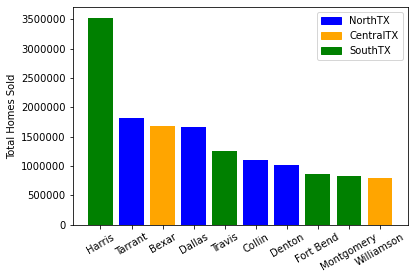

In [56]:
#get sum of total home sold by each region name, sort from regions with most home sold to least home sold, get top 10
tx_top10 = tx_housing.groupby("region_name").agg({"total_homes_sold":"sum"}).sort_values("total_homes_sold", ascending = False).iloc[:10]
import matplotlib.patches as mpatches #to assign colors for different region
fig, ax= plt.subplots()
colors = ["green", "blue", "orange", "blue", "green", "blue", "blue", "green", "green", "orange"]
ax.bar(tx_top10.index, tx_top10["total_homes_sold"], color = colors)
ax.set_ylabel("Total Homes Sold")
 #Rotate xticks labels
ax.xaxis.set_tick_params(rotation = 30)
    #assign colors/add legends for differnt regions

north_tx = mpatches.Patch(color = "blue", label = "NorthTX")
central_tx = mpatches.Patch(color = "orange", label = "CentralTX")
south_tx = mpatches.Patch(color = "green", label = "SouthTX")     

#avoid scientific notion on y axis
plt.ticklabel_format(style='plain', axis='y')
ax.legend(handles = [north_tx, central_tx, south_tx], loc = "upper right")

### Compare number of homes sold in TX vs homes sold in CA vs CO, per price range (<350k, 350-500, 500+) 
#### Stacked bar charts

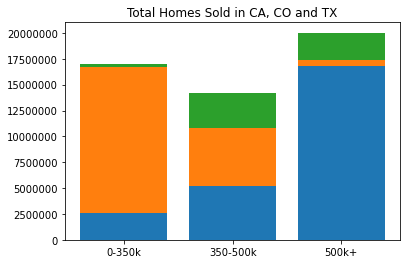

In [57]:
# get the state name from housing_raw dataframe
housing_raw = housing_raw.assign(state = housing_raw["region_name"].str[-2:])

#filter the dataframe, only get data of the 3 states
three_states = housing_raw[housing_raw["state"].isin(["TX", "CA", "CO"])]

# create 3 different median active list price bins/price range with .cut
three_states = three_states.assign(price_range = pd.cut(three_states["median_active_list_price"], [0, 350000, 500000, 2000000], labels = ["0-350k", "350-500k", "500k+"]))

# use pivot table to calculate the sum of total homes sold in each state
three_states = three_states.pivot_table(index = "price_range", columns = "state", values = "total_homes_sold", aggfunc = "sum")

# visualize total homes sold of 3 states per price range
fig, ax = plt.subplots()
ax.bar(three_states.index, three_states["CA"], label = "California")
ax.bar(three_states.index, three_states["TX"], label = "Texas", bottom = three_states["CA"])
ax.bar(three_states.index, three_states["CO"], label = "Colorado", bottom = three_states["CA"] + three_states["TX"])
ax.set_title("Total Homes Sold in CA, CO and TX")

#avoid scientific notion on y axis
plt.ticklabel_format(style='plain', axis='y')

# plt.legend(bbox_to_anchor = (1.05, 1))
plt.show()

#### Grouped Bar Charts
###### (similar as stacked bar chart- need to adjust width of bars to the left or right axis)

Text(0, 0.5, 'Total Homes sold')

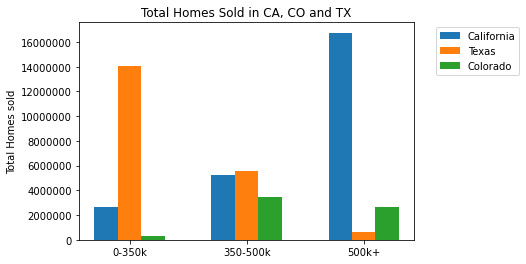

In [58]:
fig, ax = plt.subplots()
width = .2
x=np.arange(3) # 3 = length of index

ax.bar(x-width, three_states["CA"], label = "California", width = width) #shift bars to the left by half of their width
ax.bar(three_states.index, three_states["TX"], label = "Texas", width = width)
ax.bar(x+width, three_states["CO"], label = "Colorado", width = width)

#avoid scientific notion on y axis
plt.ticklabel_format(style='plain', axis='y')

ax.set_title("Total Homes Sold in CA, CO and TX")
plt.legend(bbox_to_anchor = (1.05, 1))
ax.set_ylabel("Total Homes sold")

### Use Histograms to visualize the distribution of median listing price Dallas and Austin 
##### (to see the majority of the price falls into what range)

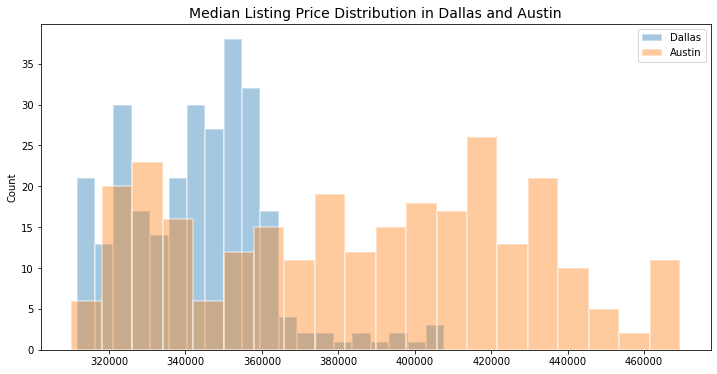

In [59]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.hist(au_da["Dallas"], bins = 20, edgecolor = "white", alpha = .4, linewidth = 2)

ax.hist(au_da["Austin"], bins = 20, edgecolor = "white", alpha = .4, linewidth = 2)
ax.legend(["Dallas", "Austin"])
ax.set_title("Median Listing Price Distribution in Dallas and Austin", fontsize = 14)
ax.set_ylabel("Count")
plt.show()